In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from xgboost import XGBRegressor

In [2]:
fuel_stats = pd.read_csv('measurements.csv')

In [3]:
fuel_stats.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [4]:
# checking out the size of the dataset
fuel_stats.shape

(388, 12)

In [5]:
fuel_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    int64 
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    int64 
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    int64 
 8   rain           388 non-null    int64 
 9   sun            388 non-null    int64 
 10  refill liters  13 non-null     object
 11  refill gas     13 non-null     object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


In [6]:
# before converting objects to int we need to clean null values
# temp_inside shows 12 rows with null values. We will drop the rows
fuel_stats['temp_inside'].isnull().sum()

12

In [7]:
# dropping the rows
fuel_stats = fuel_stats.dropna(axis=0, subset=['temp_inside'])
# converting to in 
fuel_stats['temp_inside'] = fuel_stats['temp_inside'].apply(lambda x: float(x.split()[0].replace(',', '.')))

In [8]:
#converting more objects into int

fuel_stats['distance'] = fuel_stats['distance'].apply(lambda x: float(x.split()[0].replace(',', '.')))
fuel_stats['consume'] = fuel_stats['consume'].apply(lambda x: float(x.split()[0].replace(',', '.')))

In [9]:
fuel_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       376 non-null    float64
 1   consume        376 non-null    float64
 2   speed          376 non-null    int64  
 3   temp_inside    376 non-null    float64
 4   temp_outside   376 non-null    int64  
 5   specials       91 non-null     object 
 6   gas_type       376 non-null    object 
 7   AC             376 non-null    int64  
 8   rain           376 non-null    int64  
 9   sun            376 non-null    int64  
 10  refill liters  13 non-null     object 
 11  refill gas     13 non-null     object 
dtypes: float64(3), int64(5), object(4)
memory usage: 38.2+ KB


In [10]:
# we will drop refill specials, liters, refill gas as they lack data
fuel_stats = fuel_stats.drop(['specials', 'refill liters', 'refill gas'], axis=1)

In [11]:
fuel_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 0 to 387
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   distance      376 non-null    float64
 1   consume       376 non-null    float64
 2   speed         376 non-null    int64  
 3   temp_inside   376 non-null    float64
 4   temp_outside  376 non-null    int64  
 5   gas_type      376 non-null    object 
 6   AC            376 non-null    int64  
 7   rain          376 non-null    int64  
 8   sun           376 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 29.4+ KB


In [12]:
fuel_stats['gas_type'].value_counts()

SP98    219
E10     157
Name: gas_type, dtype: int64

In [13]:
# since we want to use gas_type we will be replacing the strings with int
fuel_stats['gas_type'] = fuel_stats['gas_type'].map({
                                'E10':'1',
                                 'SP98':'0'},
                                 na_action=None)
### legend ###

# 0 == SP98
# 1 == E10

#converting the column to int
fuel_stats['gas_type'] = fuel_stats['gas_type'].astype(int)

In [14]:
fuel_stats['gas_type'].value_counts()

0    219
1    157
Name: gas_type, dtype: int64

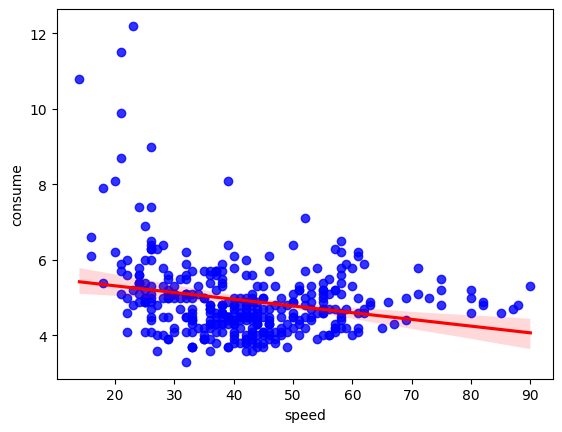

In [15]:
sns.regplot(x="speed",
            y="consume",
            scatter_kws={"color": "blue"}, line_kws={"color": "red"},
            data=fuel_stats);

# looking at the speed we can see that cars consume more fuel at lower speeds

In [16]:
#ax = fuel_stats.plot(x='temp_inside', y='consume', style='o')
#ax.set_xlabel("Temp Inside")
#ax.set_ylabel("Consumption")
#ax.set_title("Temp Inside vs. Consumption")
#plt.show()
# it is diffucult to draw any conclusions in this plot. If we dont know the outside temperature, we can only
# assume if we are heating or cooling the car. We would also need the AC parameter

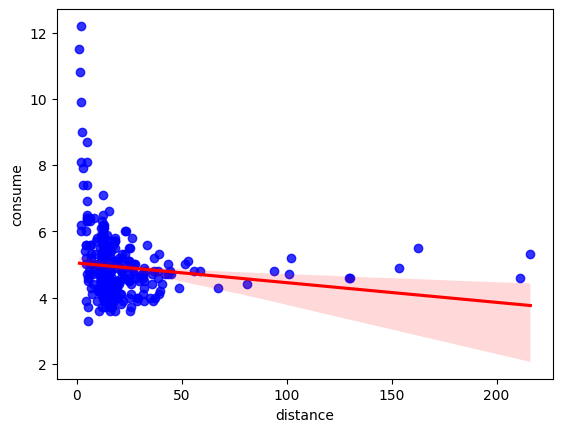

In [17]:
sns.regplot(x="distance",
            y="consume",
            scatter_kws={"color": "blue"}, line_kws={"color": "red"},
            data=fuel_stats);

# looking at the distance we can see that short distances cosnume more fuel
# maybe because of cold engine?

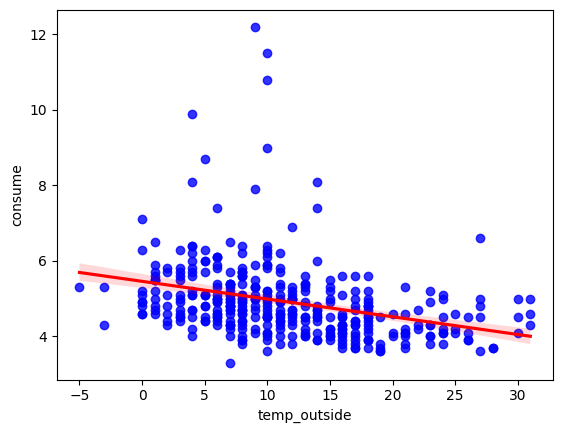

In [18]:
sns.regplot(x="temp_outside",
            y="consume",
            scatter_kws={"color": "blue"}, line_kws={"color": "red"},
            data=fuel_stats);

# looking at the outside_temp we can see that lower temperatures influence the consumption negatively

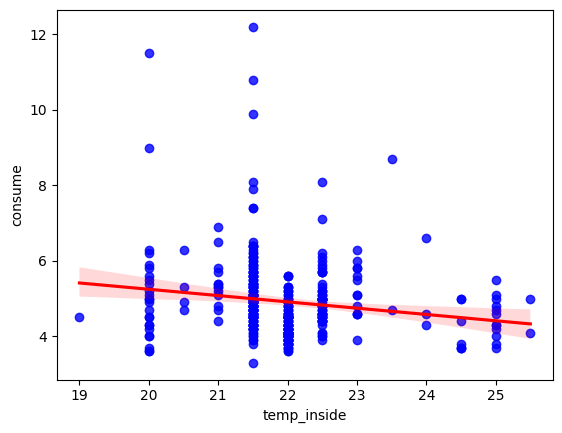

In [19]:
sns.regplot(x="temp_inside",
            y="consume",
            scatter_kws={"color": "blue"}, line_kws={"color": "red"},
            data=fuel_stats);

# it is diffucult to draw any conclusions in this plot. If we dont know the outside temperature, we can only
# assume if we are heating or cooling the car. We would also need the AC parameter

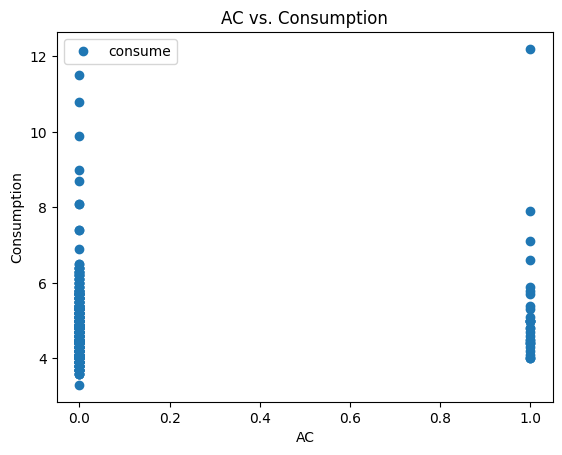

In [20]:
ax = fuel_stats.plot(x='AC', y='consume', style='o')
ax.set_xlabel("AC")
ax.set_ylabel("Consumption")
ax.set_title("AC vs. Consumption")
plt.show()
# can it be that value 1 is actually AC turned off? 

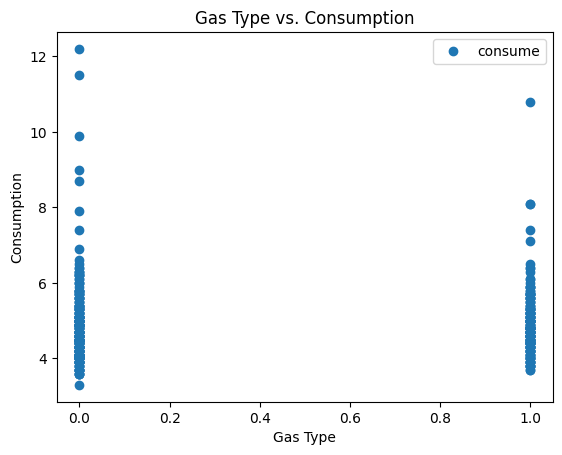

In [21]:
ax = fuel_stats.plot(x='gas_type', y='consume', style='o')
ax.set_xlabel("Gas Type")
ax.set_ylabel("Consumption")
ax.set_title("Gas Type vs. Consumption")
plt.show()
# nothing interesting to see 

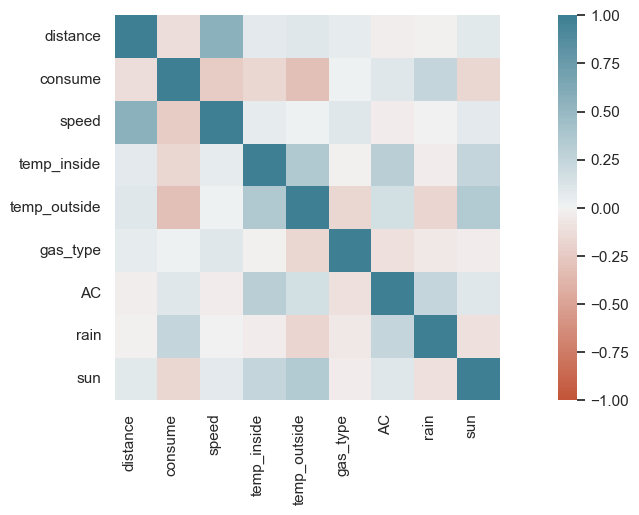

In [22]:
corr = fuel_stats.corr()
sns.set(rc = {'figure.figsize':(15,5)})

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# from the correlation matrix we can observe that 'gas_type' shows low correlation to 'consume'
# the main columns influencing consume are -> speed, temp_outside, distance, temp_inside

<AxesSubplot: title={'center': 'consume'}, xlabel='gas_type'>

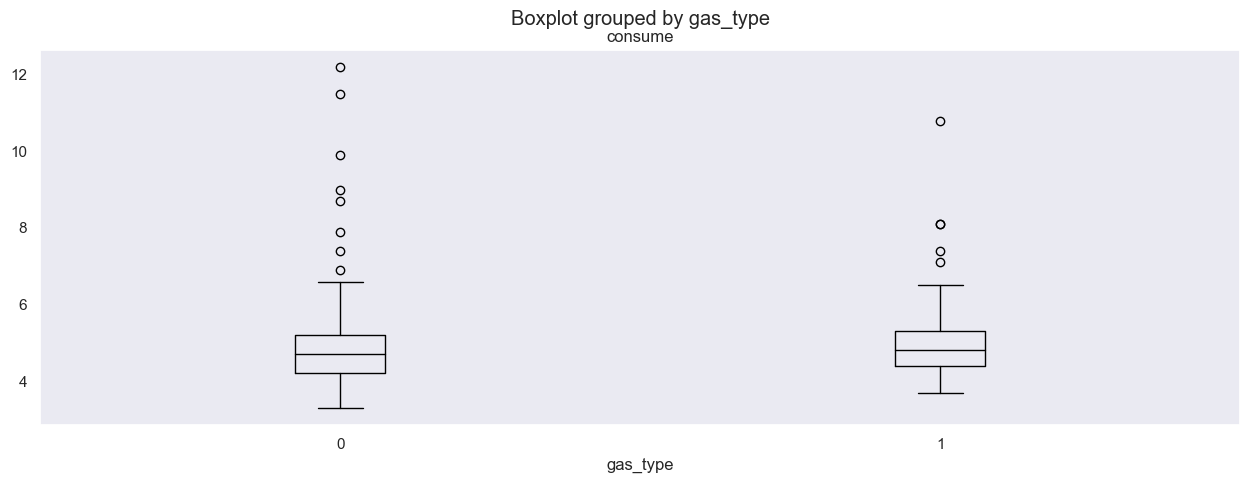

In [23]:
# looking at the difference between gas types and cosnumption
fuel_stats.boxplot(column=['consume'], by='gas_type', grid=False, color='black')
# 0 == SP98
# 1 == E10
# except for a few outliers, gas_type makes barely a difference. 0 is still a bit more economical

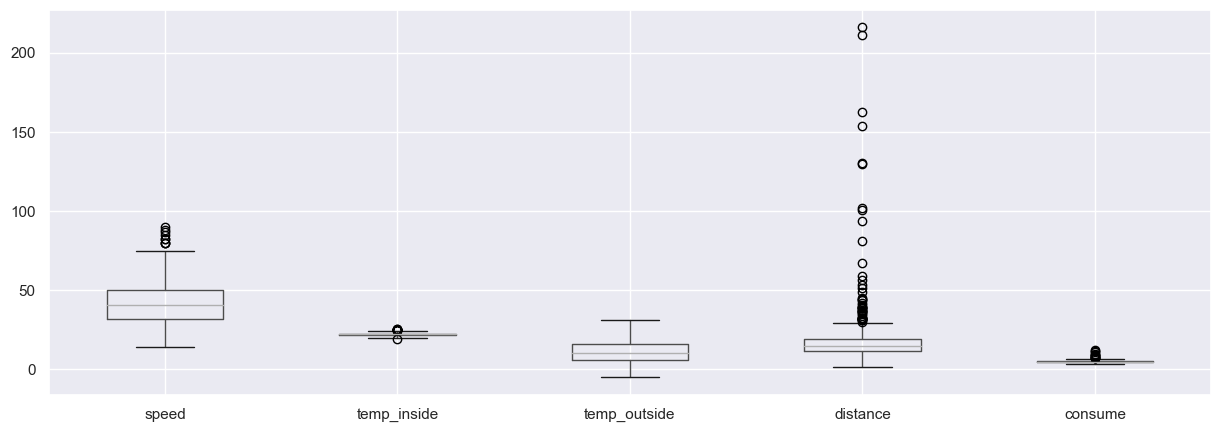

In [24]:
# looking for outlier in the dataset
boxplot = fuel_stats.boxplot(column=[
            'speed',
            'temp_inside',
            'temp_outside',
            'distance',
            'consume',]) 
plt.show()

In [25]:
# Let's train a model to predict the consumption 

In [26]:
#fuel_train = fuel_stats[['speed','temp_inside','temp_outside','gas_type','distance', 'consume']]

In [27]:
fuel_train = fuel_stats[['speed','temp_outside','gas_type','distance','sun','rain', 'AC','consume']]

In [28]:
X = fuel_train.drop(['consume'],axis=1).values
y = fuel_train['consume']

In [29]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(300, 7) (300,)
(76, 7) (76,)


In [30]:
regressor = LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [31]:
y_pred = regressor.predict(X_test) 
y_pred
# Linear regression does not show good results

array([4.93952907, 5.2156887 , 4.59923726, 4.48715179, 5.39894329,
       5.00846794, 5.52457499, 4.04762365, 4.03526552, 5.37351901,
       5.4009196 , 4.48549743, 4.70577429, 4.86358224, 4.77674515,
       4.46273763, 4.73946553, 4.26022134, 4.55346314, 6.26800202,
       6.06281438, 4.87670378, 5.9992707 , 4.68395343, 3.97723208,
       5.10261717, 4.64576705, 5.25824191, 4.9290692 , 4.6432936 ,
       4.87777277, 5.04413056, 5.26213787, 6.06357805, 4.70597917,
       4.44954417, 5.62681764, 5.27727031, 5.18921697, 5.43897559,
       5.06041518, 4.92450856, 4.89723195, 4.98868507, 3.9251277 ,
       3.69779757, 5.444085  , 3.17519096, 5.08420502, 4.92482321,
       5.67687354, 4.4784605 , 5.77503321, 5.60412277, 5.1081335 ,
       4.98965162, 4.20839195, 5.32088357, 4.39772453, 5.08657157,
       4.66523844, 5.00028695, 4.42110874, 5.17897661, 5.83286774,
       4.52860917, 4.93916983, 4.62025212, 5.13458855, 5.8378456 ,
       4.95952769, 4.94501597, 4.59054109, 4.26877123, 4.42814

In [32]:
y_test

216    4.1
132    4.5
222    5.2
356    4.2
62     5.8
      ... 
373    6.6
361    4.1
257    4.7
314    5.3
231    5.0
Name: consume, Length: 76, dtype: float64

In [36]:
xg_boost = xgb.XGBRegressor(max_depth = 5,
                            n_estimators = 100,
                            random_state=1)
xg_boost.fit(X_train, y_train)
preds_xgb = xg_boost.predict(X_test)
xg_boost.score(X_test,y_test)

0.4943845419185836

In [ ]:
# XGBoost regressor is very inefficient(low score), we need more data to train a model